# Курсовой проект для курса "Python для Data Science"

## Подключение библиотек и скриптов

In [1]:

import numpy as np
import pandas as pd

import random
import datetime
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


from sklearn.metrics import mean_squared_error as mse, r2_score as r2


import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

## Пути к директориям и файлам, константы

In [4]:
DATASET_PATH_TRAIN = '../input/real-estate-price-prediction-moscow/train.csv'
DATASET_PATH_TEST = '../input/real-estate-price-prediction-moscow/test.csv'
SUBMISSION = '../input/real-estate-price-prediction-moscow/sample_submission.csv'

ALPHA = 5

# Шаг 1. Загрузка данных <a class='anchor' id='load'>

In [5]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

**Описание датасета**

* **Id** - идентификационный номер квартиры
* **DistrictId** - идентификационный номер района
* **Rooms** - количество комнат
* **Square** - площадь
* **LifeSquare** - жилая площадь
* **KitchenSquare** - площадь кухни
* **Floor** - этаж
* **HouseFloor** - количество этажей в доме
* **HouseYear** - год постройки дома
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности
* **Social_1, Social_2, Social_3** - социальные показатели местности
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров
* **Price** - цена квартиры

In [6]:
df = pd.read_csv(DATASET_PATH_TRAIN, sep=',')
df = reduce_mem_usage(df)
df.head()

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.093750


In [7]:
df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

In [8]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.0000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315720,37.199665,6.273300,8.526700,12.6094,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214138.937500
std,4859.01902,43.587592,0.839522,21.058716,86.241219,28.560839,5.241148,6.7762,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.519470,1.493601,4.806341,92872.273438
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.0000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.0000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.0000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.0000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.0000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


# Шаг 2. EDA

## 2.1. Распределение целевой переменной

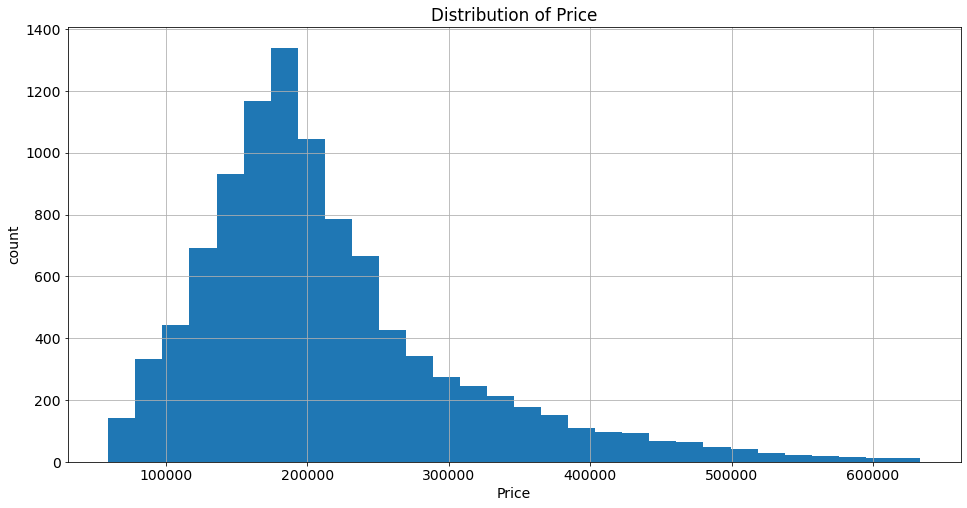

In [9]:
plt.figure(figsize = (16, 8))

df['Price'].hist(bins=30)
plt.ylabel('count')
plt.xlabel('Price')

plt.title('Distribution of Price')
plt.show()

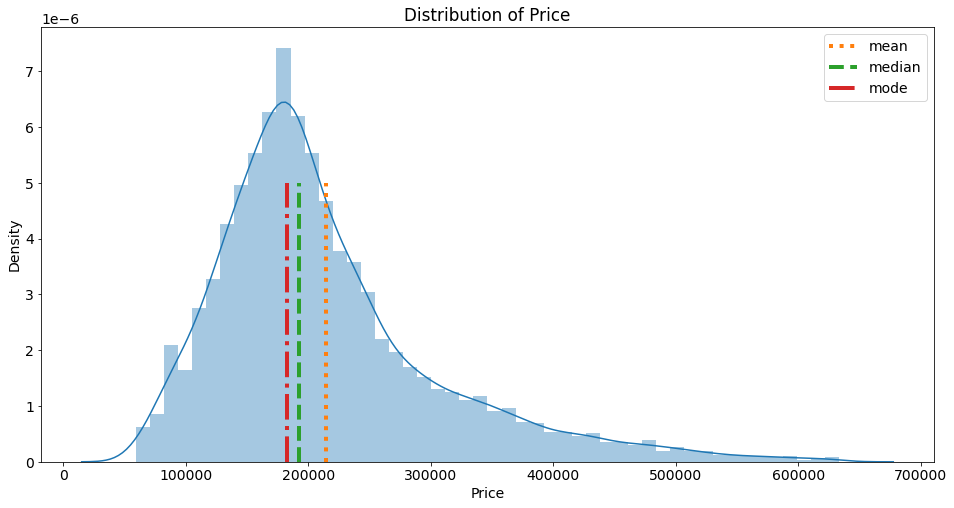

In [10]:
target_mean = round(df['Price'].mean(), 2)
target_median = df['Price'].median()
target_mode = df['Price'].mode()[0]
plt.figure(figsize = (16, 8))

sns.distplot(df['Price'], bins=50)

y = np.linspace(0, 0.000005, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

## 2.2. Анализ признаков

### 2.2.1 Количественные признаки

In [11]:
df_num_features = df.select_dtypes(include=['int16','int8','float64', 'float32', 'float16'])
df_num_features.drop('Price', axis=1, inplace=True)
df_num_features.drop('DistrictId', axis=1, inplace=True)
df_num_features.drop('Id', axis=1, inplace=True)
df_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,3.0,115.027313,NaN,10.0,4,10.0,0.075424,11,3097,0,NaN,0,0
1,1.0,39.832523,23.169222,8.0,7,8.0,0.118537,30,6207,1,1183.0,1,0
2,3.0,78.342216,47.671970,10.0,2,17.0,0.025609,33,5261,0,240.0,3,1
3,1.0,40.409908,NaN,1.0,10,22.0,0.007122,1,264,0,NaN,0,1
4,2.0,64.285065,38.562515,9.0,16,16.0,0.282798,33,8667,2,NaN,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090729,33.272625,6.0,3,12.0,0.300323,52,10311,6,NaN,1,9
9996,2.0,64.307686,37.038422,9.0,13,0.0,0.072158,2,629,1,NaN,0,0
9997,1.0,29.648056,16.555363,5.0,3,5.0,0.460556,20,4386,14,NaN,1,5
9998,1.0,32.330292,22.326870,5.0,3,9.0,0.194489,47,8004,3,125.0,3,5


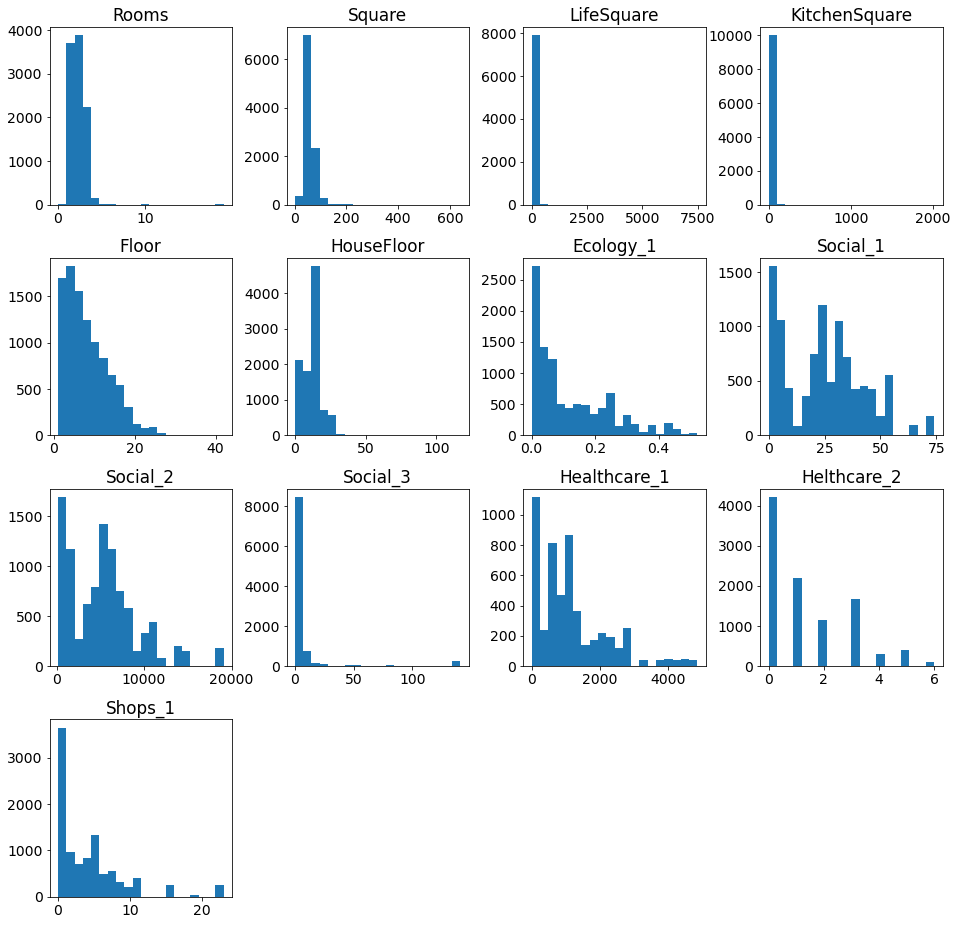

In [12]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

### 2.2.2 Категориальные признаки

In [13]:
df_cat_features = df.select_dtypes(include=['category'])

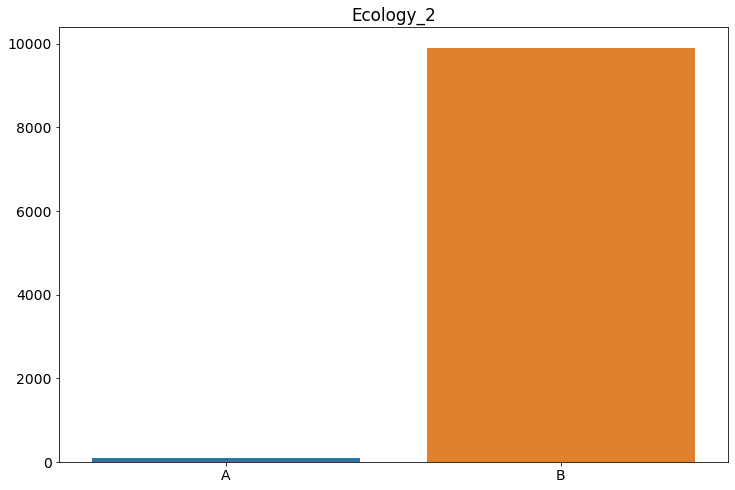

In [14]:
counts = df_cat_features['Ecology_2'].value_counts()
plt.figure(figsize=(12,8))    
plt.title('Ecology_2')
sns.barplot(counts.index, counts.values)
plt.show()

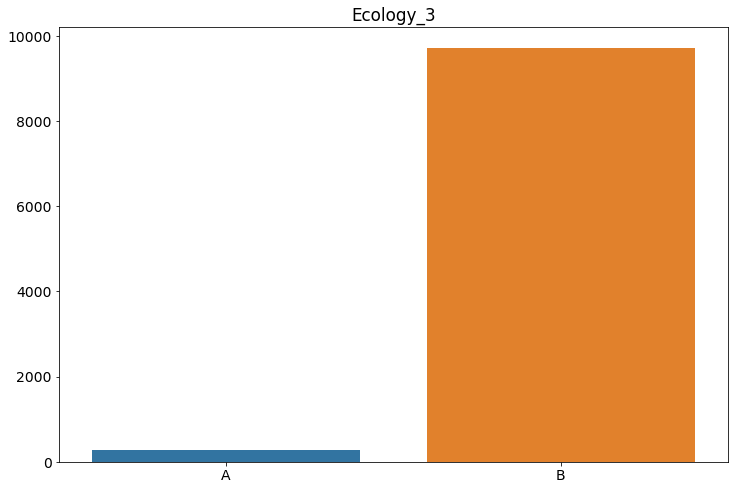

In [15]:
counts = df_cat_features['Ecology_3'].value_counts()
plt.figure(figsize=(12,8))    
plt.title('Ecology_3')
sns.barplot(counts.index, counts.values)
plt.show()

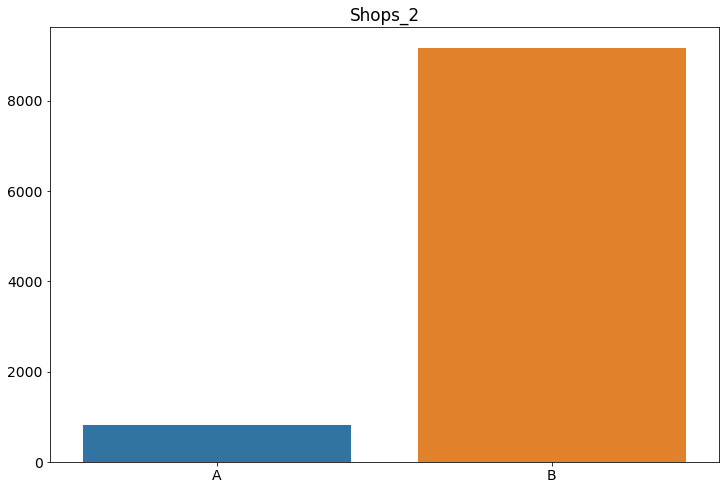

In [16]:
counts = df_cat_features['Shops_2'].value_counts()
plt.figure(figsize=(12,8))    
plt.title('Shops_2')
sns.barplot(counts.index, counts.values)
plt.show()

# Шаг 3. Предобработка данных (выбросы и пропуски) и Feature engineering

Для начала рассмотрим признаки которые могут быть обработаны исходя из понимания сути признаков:
    
    Rooms - кол-во комнат
    Square - общая блощадь квартиры
    KitchenSquare - площадь кухни
    LifeSquare - жилая площадь
    HouseFloor - этажность дома
    Floor - этаж квартиры
    HouseYear - год постройки дома

###  Шаг 3.1 Работа с выбросами

**Rooms** - количество комнат не может быть меньше 1 и маловероятно наличие более 5 комнат.
Вероятнее всего там где 0 комнат - это студии или коммуналки - проставим 1, там где более 5 поставим значение медианы

In [17]:
df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [18]:
df.loc[(df['Rooms'] == 0),'Rooms'] = 1
df.loc[(df['Rooms'] >= 6),'Rooms'] = df['Rooms'].median()

In [19]:
df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**Square** - общая блощадь квартиры, примем минимальную площадь квартиры 14 кв. м. Заменим все значения меньше этой величины на указанную.

In [20]:
df['Square'].min(),df['Square'].max()

(1.1368588209152222, 641.065185546875)

In [21]:
df.loc[(df['Square'] < 14),'Square'] = 14

In [22]:
df['Square'].min(),df['Square'].max()

(14.0, 641.065185546875)

**KitchenSquare** - площадь кухни, значения в признаке есть как очень большие так и очень маленькие. Выбросом будем считать все что больше уровня значимости ALPHA/2 (т.к. ошибка может быть как в большую так и в меньшую сторону). Выберем значения по данным квантилям. Все что больше либо равно верхнему порогу - заменим на квантиль 75%. Примем минимальную площадь кухни - 5 кв м, все что меньше заменим на указанную величину.

In [23]:
df['KitchenSquare'].value_counts().head()

1.0     2460
8.0     1306
5.0     1169
10.0    1075
6.0     1038
Name: KitchenSquare, dtype: int64

In [24]:
q75 = df['KitchenSquare'].quantile(.75)
q_hight_alpha = df['KitchenSquare'].quantile(1-(ALPHA/2)/100)
df.loc[(df['KitchenSquare'] >= q_hight_alpha),'KitchenSquare'] = q75
df.loc[(df['KitchenSquare'] <= 5),'KitchenSquare'] = 5

In [25]:
df['KitchenSquare'].value_counts()

5.0     4391
8.0     1306
9.0     1099
10.0    1075
6.0     1038
7.0      609
12.0     249
11.0     233
Name: KitchenSquare, dtype: int64

**LifeSquare** - жилая площадь не должна быть больше чем общая площадь за вычетом площади кухни и 3х кв. м (на санузел и прочие нежилые части помещения), если такая ситуация возникает заменяем значение жилой площади на значение разности общей площади и кухни и 3 кв. м. Если жилая площадь в 2 и более раза меньше чем разность общей площади, площади кухни и 3 кв. м - заменяем значение на значение разности общей площади и кухни и 3 кв. м. Пропуски жилой площади обработаем отдельно

In [26]:
df.loc[df['LifeSquare'] > df['Square'] - df['KitchenSquare'] - 3]['LifeSquare'].count()

1259

In [27]:
df.loc[(df['LifeSquare'] > df['Square'] - df['KitchenSquare'] - 3),'LifeSquare'] = df['Square'] - df['KitchenSquare'] - 3

In [28]:
df.loc[df['LifeSquare'] > df['Square'] - df['KitchenSquare'] - 3]['LifeSquare'].count()

0

In [29]:
df.loc[df['LifeSquare'] < (df['Square'] - df['KitchenSquare'] - 3)/2]['LifeSquare'].count()

249

In [30]:
df.loc[(df['LifeSquare'] < (df['Square'] - df['KitchenSquare'] - 3)/2),['LifeSquare']] = df['Square'] - df['KitchenSquare'] - 3

In [31]:
df.loc[df['LifeSquare'] < (df['Square'] - df['KitchenSquare'] - 3)/2]['LifeSquare'].count()

0

**HouseFloor** - высота здания. Примем максимальную этажность здания 95. Все что выше заменяем на медиану этажности. Так же заменим здания с 0ой этажностью на медиану

In [32]:
df['HouseFloor'].min(),df['HouseFloor'].max()

(0.0, 117.0)

In [33]:
df.loc[(df['HouseFloor'] == 0) | (df['HouseFloor'] >= 95), 'HouseFloor'] = df['HouseFloor'].median()

In [34]:
df['HouseFloor'].min(),df['HouseFloor'].max()

(1.0, 48.0)

**Floor** - этаж квартиры. Если значение этажа квартиры более этажности дома - заменяем этаж на случайно сгенерированный этаж в пределах этажности дома

In [35]:
df[df['Floor'] > df['HouseFloor']]['Floor'].value_counts()

6     204
10    161
7     129
18    124
11     98
13     96
4      93
5      82
14     72
19     67
17     59
3      54
15     53
9      50
16     49
12     39
8      38
2      26
24     23
20     18
21     18
25     18
26     16
22     11
23      6
27      5
28      1
Name: Floor, dtype: int64

In [36]:
df.loc[df['Floor'] > df['HouseFloor'], 'Floor'] = df.loc[df['Floor'] > df['HouseFloor'], 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [37]:
df[df['Floor'] > df['HouseFloor']]['Floor'].value_counts()

Series([], Name: Floor, dtype: int64)

**HouseYear** - год постройки. Все значения года постройки превышающий текущий год заменим на текущий.

In [38]:
year = datetime.datetime.now().year

In [39]:
df[df['HouseYear']>year]['HouseYear'].count()

2

In [40]:
df.loc[df['HouseYear']>year,'HouseYear'] = year

In [41]:
df[df['HouseYear']>year]['HouseYear'].count()

0

###  Шаг 3.2 Работа с пропусками

In [42]:
df.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

Имеем 2 признака с пропусками:

    1. LifeSquare - Жилая площадь пропусков достаточно много, но можно постаратсья восстановить признак, при этом он может существенно влиять на стоимость
    2. Healthcare_1 - показатель связанный с охраной здоровья, пропусков очень много почти 50% - так же постараемся восстановить

**LifeSquare** - пропуски жилой площади будем заполнять следущими расчетными данными. Определим значение коэфициента отношения общей площади к жилой (для домов с имеющимися данными по жилой площади) группируя по DistrictId, HouseYear и этажности дома. Полученный коэфициент будем умножать на известное значение общей площади квартиры, и использовать результат вычисления в качестве жилой площади при условии что данное значение будет не больше чем разница общей площади, площади кухни и 3 кв. м, если условие не выполняется, то пропуск будет заполняться значением разницы общей площади, площади кухни и 3 кв. м.

In [43]:
df_ls_coef = df[df['LifeSquare'].notna()][['DistrictId','HouseYear','HouseFloor','Square','LifeSquare']]
df_ls_coef = df_ls_coef.groupby(by=['DistrictId','HouseYear','HouseFloor']).sum().reset_index()
df_ls_coef['LS_coef'] = df_ls_coef['LifeSquare'] / df_ls_coef['Square']
df_ls_coef.drop('Square', axis=1, inplace=True)
df_ls_coef.drop('LifeSquare', axis=1, inplace=True)
df = df.merge(df_ls_coef, on=(['DistrictId','HouseYear','HouseFloor']))
df['LS_calc'] = df.Square * df.LS_coef
df.loc[(df.LifeSquare.isna()) & (df['LS_calc'] <= df['Square'] - df['KitchenSquare'] - 3),'LifeSquare'] = df['LS_calc']
df.loc[(df.LifeSquare.isna()) & (df['LS_calc'] > df['Square'] - df['KitchenSquare'] - 3),'LifeSquare'] = df['Square'] - df['KitchenSquare'] - 3
df.drop('LS_coef', axis=1, inplace=True)
df.drop('LS_calc', axis=1, inplace=True)

**Healthcare_1** - т.к. данный признак в теории должен описывать ситуацию по охране здоровья в районе квартиры  предполагаем, что пропуски могут быть заполнены медианой значений по району (DistrictId). А оставшиеся пропуски заполнены медианой по всем наблюдениям.

In [44]:
median_healthcare_1_by_district = df.groupby(['DistrictId'], as_index=False)\
                                    .agg({'Healthcare_1':'median'})\
                                    .rename(columns={'Healthcare_1':'MedianHealthcare1ByDistrictRooms'})
median_healthcare_1_by_district_median = median_healthcare_1_by_district['MedianHealthcare1ByDistrictRooms'].median()

In [45]:
df = df.merge(median_healthcare_1_by_district, on=(['DistrictId']), how='left')
df.loc[(df.Healthcare_1.isna()) & (df.MedianHealthcare1ByDistrictRooms.notna()),'Healthcare_1'] = df.MedianHealthcare1ByDistrictRooms
df.fillna({'Healthcare_1':median_healthcare_1_by_district_median}, inplace=True)

###  Шаг 3.3 Feature engineering

**Dummies кодирование**

Всего имеем 3 категориальных признака которые можно закодировать бинарно:
1.   Ecology_2
2.   Ecology_3
3.   Shops_2

In [46]:
binary_to_numbers = {'A': 0, 'B': 1}
df['Ecology_2'] = df['Ecology_2'].replace(binary_to_numbers)
df['Ecology_3'] = df['Ecology_3'].replace(binary_to_numbers)
df['Shops_2'] = df['Shops_2'].replace(binary_to_numbers)

**Средняя стоимость в зависимости от района и комнат**

In [47]:
median_price_by_district_rooms = df.groupby(['DistrictId', 'Rooms'], as_index=False)\
                                   .agg({'Price':'median'})\
                                   .rename(columns={'Price':'MedianPriceByDistrictRooms'})
median_price_by_district_rooms_median = median_price_by_district_rooms['MedianPriceByDistrictRooms'].median()
df = df.merge(median_price_by_district_rooms, on=['DistrictId', 'Rooms'], how='left')   
df.fillna({'MedianPriceByDistrictRooms':median_price_by_district_rooms_median}, inplace=True)

**Средняя стоимость в зависимости от этажности и возраста дома**

Добавим категорию этажности с разбиением на 5

In [48]:
df['Floor_cat'] = (df.HouseFloor//5).astype(int)

Добавим категорию возраста дома разбив на десятилетия

In [49]:
df['HouseYear_cat'] = (df.HouseYear//10).astype(int)*10

In [50]:
median_price_by_floor_year = df.groupby(['HouseYear_cat', 'Floor_cat'], as_index=False)\
                               .agg({'Price':'median'})\
                               .rename(columns={'Price':'MedianPriceByFloorYear'})
median_price_by_floor_year_median = median_price_by_floor_year['MedianPriceByFloorYear'].median()
df = df.merge(median_price_by_floor_year, on=['HouseYear_cat', 'Floor_cat'], how='left')   
df.fillna({'MedianPriceByFloorYear':median_price_by_floor_year_median}, inplace=True)

###  Шаг 3.4 Классы для предобработки и Feature engineering

In [51]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.quantile_75 = None
        self.quantile_hight_alpha = None
        self.mean_healthcare_1_by_district = None
        self.MIN_SQUARE = 14
        self.MIN_NON_RESIDENTIAL_AREA = 3
        self.MAX_HOUSE_FLOOR = 95
        self.MIN_KITCHEN_SQUARE = 5
        self.df_ls_coef = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        self.medians = X.median()
        self.quantile_75 = X['KitchenSquare'].quantile(.75)
        self.quantile_hight_alpha = X['KitchenSquare'].quantile(1-(ALPHA/2)/100)
        self.median_healthcare_1_by_district = X.groupby(['DistrictId'], as_index=False)\
                                                .agg({'Healthcare_1':'median'})\
                                                .rename(columns={'Healthcare_1':'MedianHealthcare1ByDistrictRooms'})
        self.median_healthcare_1_by_district_median = self.median_healthcare_1_by_district['MedianHealthcare1ByDistrictRooms']\
                                                          .median()
        self.df_ls_coef = X[X['LifeSquare'].notna()][['DistrictId','HouseYear','HouseFloor','Square','LifeSquare']]
        self.df_ls_coef = self.df_ls_coef.groupby(by=['DistrictId','HouseYear','HouseFloor'])\
                                         .sum()\
                                         .reset_index()
        self.df_ls_coef['LS_coef'] = self.df_ls_coef['LifeSquare'] / self.df_ls_coef['Square']
        self.df_ls_coef.drop('Square', axis=1, inplace=True)
        self.df_ls_coef.drop('LifeSquare', axis=1, inplace=True)
        
    def transform(self, X):
        """Трансформация данных"""

        # Обработка выбросов
        # Rooms
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        #Square 
        X.loc[X['Square'] < self.MIN_SQUARE, 'Square'] = self.MIN_SQUARE
        
        # KitchenSquare
        X.loc[(X['KitchenSquare'] >= self.quantile_hight_alpha),'KitchenSquare'] = self.quantile_75
        X.loc[(X['KitchenSquare'] <= self.MIN_KITCHEN_SQUARE),'KitchenSquare'] = self.MIN_KITCHEN_SQUARE
        
        #LifeSquare
        X.loc[(X['LifeSquare'] > X['Square'] - X['KitchenSquare'] - self.MIN_NON_RESIDENTIAL_AREA),'LifeSquare'] \
          = X['Square'] - X['KitchenSquare'] - self.MIN_NON_RESIDENTIAL_AREA
        X.loc[(X['LifeSquare'] <= (X['Square'] - X['KitchenSquare'] - self.MIN_NON_RESIDENTIAL_AREA)/2),['LifeSquare']] \
          = X['Square'] - X['KitchenSquare'] - self.MIN_NON_RESIDENTIAL_AREA
        
        #HouseFloor
        X.loc[(X['HouseFloor'] == 0) | (X['HouseFloor'] >= self.MAX_HOUSE_FLOOR), 'HouseFloor'] \
          = X['HouseFloor'].median()
        
        #Floor
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] \
          = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor'].apply(lambda x: random.randint(1, x))
        
        #HouseYear
        year = datetime.datetime.now().year
        X.loc[X['HouseYear']>year,'HouseYear'] = year
        
        # Обработка пропусков
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X = X.merge(self.median_healthcare_1_by_district, 
                        on=(['DistrictId']), 
                        how='left')
            X.loc[(X.Healthcare_1.isna()) & (X.MedianHealthcare1ByDistrictRooms.notna()),
                  'Healthcare_1'] = X.MedianHealthcare1ByDistrictRooms
            X.fillna({'Healthcare_1':median_healthcare_1_by_district_median},
                     inplace=True)
            X.drop('MedianHealthcare1ByDistrictRooms', axis=1, inplace=True)
            
        # LifeSquare        
        X = X.merge(self.df_ls_coef, 
                    on=(['DistrictId','HouseYear','HouseFloor']), 
                    how='left')
        X['LS_calc'] = X.Square * X.LS_coef
        X.loc[(X.LifeSquare.isna()) & (X['LS_calc'] <= X['Square'] - X['KitchenSquare'] - self.MIN_NON_RESIDENTIAL_AREA),'LifeSquare'] \
          = X['LS_calc']
        X.loc[(X.LifeSquare.isna()) & (X['LS_calc'] > X['Square'] - X['KitchenSquare'] - self.MIN_NON_RESIDENTIAL_AREA),'LifeSquare'] \
          = X['Square'] - X['KitchenSquare'] - self.MIN_NON_RESIDENTIAL_AREA
        X.loc[(X.LifeSquare.isna()) & (X.LS_calc.isna()),'LifeSquare'] \
          = X['Square'] - X['KitchenSquare'] - self.MIN_NON_RESIDENTIAL_AREA
        X.drop('LS_coef', axis=1, inplace=True)
        X.drop('LS_calc', axis=1, inplace=True)
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [52]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.binary_to_numbers = None
        self.median_price_by_district_rooms = None
        self.median_price_by_floor_year = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts()\
                                            .reset_index()\
                                            .rename(columns={'index':'DistrictId', 
                                                             'DistrictId':'DistrictSize'})
        # Target encoding
        ## District, Rooms
        df_copy = X.copy()
        
        if y is not None:
            df_copy['Price'] = y.values
            self.median_price_by_district_rooms = df_copy.groupby(['DistrictId', 'Rooms'], as_index=False)\
                                                         .agg({'Price':'median'})\
                                                         .rename(columns={'Price':'MedianPriceByDistrictRooms'})
            self.median_price_by_district_rooms_median = self.median_price_by_district_rooms['MedianPriceByDistrictRooms']\
                                                             .median()
            
        ## floor, year
        if y is not None:
            df_copy['Price'] = y.values
            df_copy = self.floor_to_cat(df)
            df_copy = self.year_to_cat(df)
            self.median_price_by_floor_year = df_copy.groupby(['Floor_cat', 'HouseYear_cat'], as_index=False)\
                                                     .agg({'Price':'median'})\
                                                     .rename(columns={'Price':'MedianPriceByFloorYear'})
            self.median_price_by_floor_year_median = self.median_price_by_floor_year['MedianPriceByFloorYear']\
                                                         .median()
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        X['DistrictSize'].fillna(5, inplace=True)
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.median_price_by_district_rooms is not None:
            X = X.merge(self.median_price_by_district_rooms, on=['DistrictId', 'Rooms'], how='left')
            X.fillna({'MedianPriceByDistrictRooms': self.median_price_by_district_rooms_median}, inplace=True)
            
        if self.median_price_by_floor_year is not None:
            X = X.merge(self.median_price_by_floor_year, on=['HouseYear_cat', 'Floor_cat'], how='left')
            X.fillna({'MedianPriceByFloorYear': self.median_price_by_floor_year_median}, inplace=True)
        
        # Feature encoding
        X['isFirstFloor'] = 0
        X['isLastFloor'] = 0
        X['meanLifeSquarebyRoom'] = 0
        X.loc[(X['Floor'] == 1), 'isFirstFloor'] = 1
        X.loc[(X['Floor'] == X['HouseFloor']), 'isLastFloor'] = 1
        X['meanLifeSquarebyRoom'] = X['LifeSquare']/X['Rooms']
        X['meanSquarebyRoom'] = X['Square']/X['Rooms']
        
        return X
    
    def floor_to_cat(self, X):
        X['Floor_cat'] = (X.HouseFloor//5).astype(int)
        return X
     
    def year_to_cat(self, X):  
        X['HouseYear_cat'] = (X.HouseYear//10).astype(int)*10
        return X

In [53]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3','Healthcare_1',
                 'Helthcare_2', 'Shops_2']

new_feature_names = ['MedianPriceByFloorYear','DistrictSize','isFirstFloor','isLastFloor','meanLifeSquarebyRoom','meanSquarebyRoom']

target_name = 'Price'

In [54]:
train_df = pd.read_csv(DATASET_PATH_TRAIN)
test_df = pd.read_csv(DATASET_PATH_TEST)
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [55]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [56]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 19), (3300, 19), (5000, 19))

In [57]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)
X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 30), (3300, 30), (5000, 30))

In [58]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [59]:
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_valid = pd.DataFrame(scaler.transform(X_valid))
test_df = pd.DataFrame(scaler.transform(test_df))

In [60]:
model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=20,
                                     min_samples_leaf=24,
                                     random_state=21,  
                                     n_estimators=265, 
                                     max_features='sqrt', 
                                     loss='huber', 
                                     learning_rate=0.025)
model.fit(X_train, y_train)

GradientBoostingRegressor(criterion='mse', learning_rate=0.025, loss='huber',
                          max_depth=20, max_features='sqrt',
                          min_samples_leaf=24, n_estimators=265,
                          random_state=21)

Train R2:	0.877
Test R2:	0.765


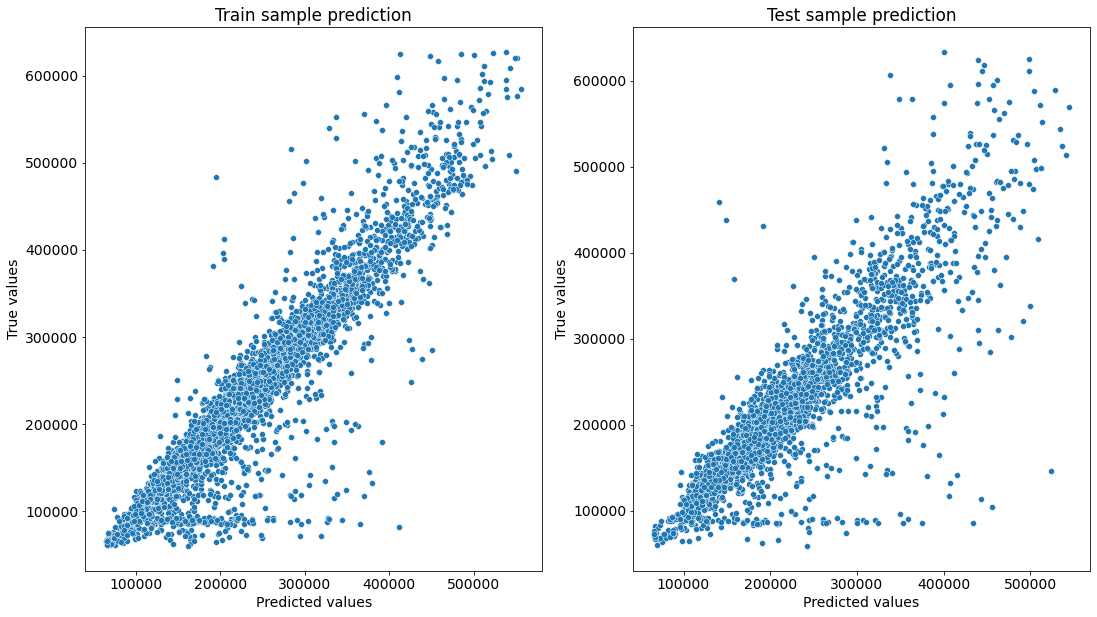

In [61]:
y_train_preds = model.predict(X_train)
y_test_preds = model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [62]:
cv_score = cross_val_score(model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.75028357, 0.71152631, 0.74375665])

In [63]:
submit = pd.read_csv(SUBMISSION)
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [64]:
predictions = model.predict(test_df)
predictions

array([162376.78665884, 118296.63671215, 142527.68642526, ...,
       148339.72746787, 187551.25212675, 270634.01714042])

In [65]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,162376.786659
1,5925,118296.636712
2,960,142527.686425
3,3848,126308.534816
4,746,205660.769985


In [66]:
submit.shape

(5000, 2)

In [67]:
submit.to_csv('submit.csv', index=False)